# Детектирование кошек на изображениях 

## Библиотеки

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dense
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, preprocess_input
from sklearn.metrics import classification_report
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

In [ ]:
# Монтирование для доступа в гугл-диск
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Подготовка данных

In [ ]:
# Загрузка датасета
path = 'drive/MyDrive/cat_det/the-oxfordiiit-pet-dataset/images/images/'
data = [(str(img), '_'.join(str(img).split('/')[-1].split('_')[:-1])) for img in glob.glob(path + '*.jpg')]
data = pd.DataFrame(data, columns=['filename', 'label'])
# Разбиение на тренировочную и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2)
# Количество уникальных пород
n_labels = data['label'].nunique()

In [ ]:
n_labels

37

In [ ]:
train_data.head()

,filename,label
7173,drive/MyDrive/input/the-oxfordiiit-pet-dataset...,Abyssinian
6026,drive/MyDrive/input/the-oxfordiiit-pet-dataset...,Birman
7140,drive/MyDrive/input/the-oxfordiiit-pet-dataset...,Abyssinian
4805,drive/MyDrive/input/the-oxfordiiit-pet-dataset...,beagle
4412,drive/MyDrive/input/the-oxfordiiit-pet-dataset...,basset_hound


## Модели

### ResNet

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Задание генератора
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Тренировочный генератор
train_gen = data_gen.flow_from_dataframe(dataframe=train_data,
                                         x_col="filename",
                                         y_col="label",
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         )

# Валидационный генератор
val_gen = data_gen.flow_from_dataframe(dataframe=test_data, 
                                       x_col="filename",
                                       y_col="label",
                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size=BATCH_SIZE,
                                       class_mode='categorical',
                                       shuffle=False,
                                       )

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Создание модели
model_rn = Sequential()

# Fine-tuning ResNet добавлением дополнительного слоя и заморозкой слоев ResNet
# Добавление предобученного ResNet 
model_rn.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model_rn.layers[0].trainable = False

# Добавление доп. слоя
model_rn.add(Dense(n_labels))
model_rn.add(Activation('sigmoid'))

# Настройка модели
model_rn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy']
              )

# Количество батчей
steps_train = np.ceil(train_data.shape[0] / BATCH_SIZE)
steps_val = np.ceil(test_data.shape[0] / BATCH_SIZE)

# Обучение модели
model_rn.fit_generator(train_gen,
                    steps_per_epoch=steps_train,
                    validation_data=val_gen,
                    epochs=20,
                    validation_steps=steps_val,
                    verbose=1,
                    )

Found 5912 validated image filenames belonging to 37 classes.
Found 1478 validated image filenames belonging to 37 classes.
94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_rn.save_weights("drive/MyDrive/cat_det/model_rn.h5")

In [ ]:
model_rn.load_weights("drive/MyDrive/cat_det/model_rn.h5")

In [ ]:
# Оценка модели
model_rn.evaluate_generator(val_gen, steps_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.005115988664329052, 0.9837618470191956]

In [ ]:
# Формирование отчета по разным метрикам
predictions = model_rn.predict_generator(val_gen, verbose=1)
test_labels = val_gen.classes
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


47/47 [==============================] - 17s 335ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.97      1.00      0.99        34
           2       0.96      0.98      0.97        47
           3       0.97      1.00      0.98        56
           4       0.97      0.95      0.96        39
           5       1.00      0.92      0.96        36
           6       1.00      1.00      1.00        38
           7       1.00      1.00      1.00        42
           8       1.00      1.00      1.00        37
           9       0.97      0.95      0.96        40
          10       0.98      0.96      0.97        46
          11       1.00      1.00      1.00        46
          12       0.90      0.95      0.92        39
          13       0.91      0.97      0.94        32
          14       0.98      0.98      0.98        44
          15       1.00      1.00      1.00        46
          16       1.00  

### YOLO

In [ ]:
weights_path = 'drive/MyDrive/cat_det/yolo-coco-data/yolov3.weights'
config_path = 'drive/MyDrive/cat_det/yolo-coco-data/yolov3.cfg'
# Нижняя граница вероятности для отсеивания боксов
prob_min = 0.98

In [ ]:
# Задание YOLO модели
model_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)
# Определение выходных слоев
yolo_lnames = model_yolo.getLayerNames()
yolo_onames = [yolo_lnames[i[0] - 1] for i in model_yolo.getUnconnectedOutLayers()]

### Обработка изображения

In [ ]:
# Определение породы по ее номеру
def class_from_num(n):
    return np.sort(data['label'].unique())[n]

In [ ]:
# Определение пород на изображении
def detect_and_classify(filename):
    # Считывание файла
    img = cv2.imread(filename)

    # Предобработка картинки
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), 
                                 swapRB=True, crop=False)
    # Подача блоба в YOLO
    model_yolo.setInput(blob)
    # Получение результата из YOLO
    yolo_res = model_yolo.forward(yolo_onames)
    
    bounding_boxes = []
    confidences = []
    h = img.shape[0]
    w = img.shape[1]
    threshold = 0.3

    # Распределение полученных боксов по массивам
    for result in yolo_res:
        for detection in result:
            scores = detection[5:]
            class_cur = np.argmax(scores)

            confidence_cur = scores[class_cur]

            if confidence_cur > prob_min:

                box_cur = detection[0:4] * np.array([w, h, w, h])

                x_center, y_center, box_width, box_height = box_cur.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_cur))

    # Non-maximum suppression - отсеивание боксов
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, prob_min, threshold)

    # Определение отсеянных боксов в массив
    box_coors = []
    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            box_coors.append([x_min, y_min, box_width, box_height])
                
    # Цвет бокса
    colour_box = (0, 0, 255)    
    # Выделение областей картинки по боксам -> получение массива картинок 
    cropped_imgs = [img[coor[1]:coor[1]+coor[3], coor[0]:coor[0]+coor[2]] for coor in box_coors]
    
    # Форматирование картинок по цвету и размеру
    for i in range(len(cropped_imgs)):
        cropped_imgs[i] = cv2.cvtColor(cropped_imgs[i], cv2.COLOR_BGR2RGB)
        cropped_imgs[i] = cv2.resize(cropped_imgs[i], (224, 224))
        
    # Предобработка картинок
    input_imgs = np.array([preprocess_input(i) for i in cropped_imgs])

    # Получение предсказания
    preds = model_rn.predict(input_imgs)
        
    # Добавление боксов и предсказаний на исходное изображение
    for i, cr in enumerate(box_coors):
        
        cv2.rectangle(img, 
                      (cr[0], cr[1]),
                      (cr[0] + cr[2], cr[1] + cr[3]),
                      colour_box, 
                      1,
                      )
        cv2.putText(img, 
                    class_from_num(np.argmax(preds[i])),
                    (cr[0], cr[1]),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5,
                    colour_box,
                    2,
                    )
    
    # Отображение результата
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Результаты

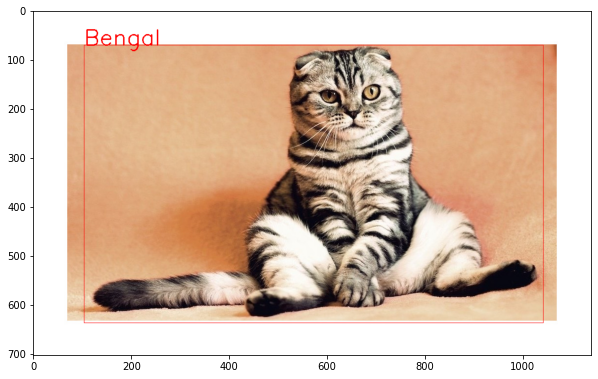

In [ ]:
detect_and_classify('drive/MyDrive/cat_det/cats/1.jpg')

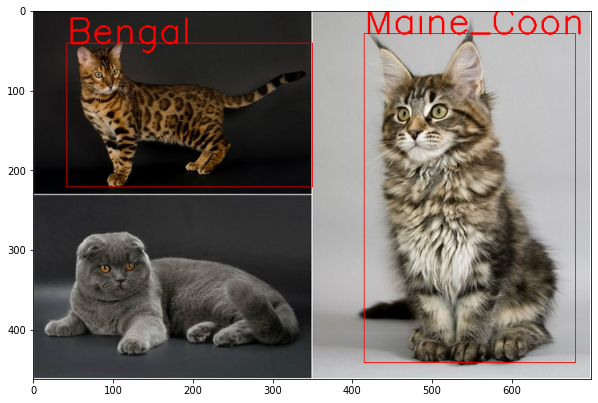

In [ ]:
detect_and_classify('drive/MyDrive/cat_det/cats/2.jpg')

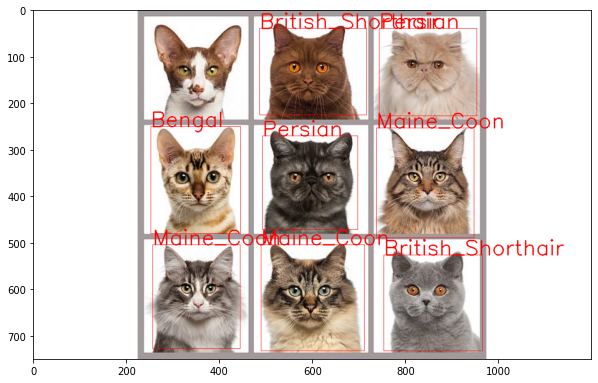

In [ ]:
detect_and_classify('drive/MyDrive/cat_det/cats/3.jpg')

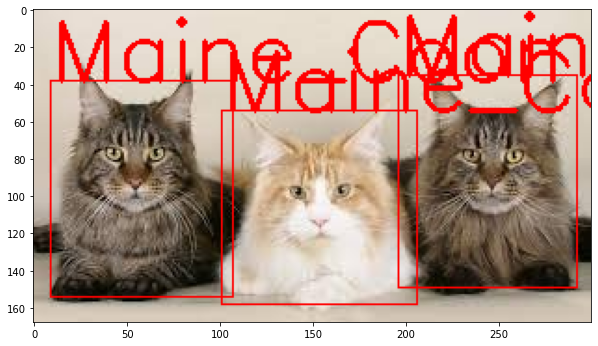

In [ ]:
detect_and_classify('drive/MyDrive/cat_det/cats/4.jpg')